## Model with Masked inputs

### Data Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

### Traning and evaluation functions

In [2]:
class MatchDatasetWithMask(Dataset):
    def __init__(self, df, image_folder, mask_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = str(row['Image Number']) + '.jpg'
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        mask_name = str(row['Image Number']) + '_mask.png'
        mask_path = os.path.join(self.mask_folder, mask_name)
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L') 
        else:
            # we want black mask if no ball present
            mask = Image.new('L', image.size, 0) 
        
        if self.transform:
            image = self.transform(image)
            
            # transform for mask without normalization
            mask_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)

        input_tensor = torch.cat([image, mask], dim=0)
        
        label = row['label']
        return input_tensor, label

In [3]:
class ResNet18With4Channels(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18With4Channels, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)

        self.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        with torch.no_grad():
            old_weights = models.resnet18(pretrained=True).conv1.weight
            new_weights = torch.zeros(64, 4, 7, 7)
            new_weights[:, :3, :, :] = old_weights
            new_weights[:, 3, :, :] = old_weights.mean(dim=1)  # average weights for the 4th channel
            self.resnet.conv1.weight = nn.Parameter(new_weights)
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_save_path):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_loss = float('inf')

    print(f"Training on device: {device}")
    print(f"Input shape will be: [batch_size, 4, 224, 224]")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for i, (images, labels_batch) in enumerate(train_loader):
            images, labels_batch = images.to(device), labels_batch.to(device)

            if epoch == 0 and i == 0:
                print(f"Input tensor shape: {images.shape}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for images, labels_batch in val_loader:
                images, labels_batch = images.to(device), labels_batch.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels_batch)

                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels_batch).sum().item()
                val_total += labels_batch.size(0)

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total * 100
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), model_save_path)
            print("Saved new best model!\n")

    print("Training complete.")
    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

### Data Loading

In [5]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)
labels = labels.drop(columns=LABELS)


In [6]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

---
## 1.   Ball masked inputs

In [7]:
image_path = 'data/selected_images'
mask_path = 'data/Ball_Mask'

In [18]:

train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [19]:
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='resnet18_masked_Ball.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]
Input tensor shape: torch.Size([32, 4, 224, 224])


[1/10] Train Loss: 0.8550, Acc: 70.11%, Val Loss: 0.5794, Acc: 79.38%
Saved new best model!

[2/10] Train Loss: 0.5674, Acc: 80.04%, Val Loss: 0.5437, Acc: 80.38%
Saved new best model!

[3/10] Train Loss: 0.4391, Acc: 84.40%, Val Loss: 0.4835, Acc: 84.12%
Saved new best model!

[4/10] Train Loss: 0.3567, Acc: 87.47%, Val Loss: 0.5761, Acc: 80.62%
[5/10] Train Loss: 0.3134, Acc: 88.94%, Val Loss: 0.4479, Acc: 85.50%
Saved new best model!

[6/10] Train Loss: 0.2109, Acc: 92.46%, Val Loss: 0.6542, Acc: 81.62%
[7/10] Train Loss: 0.1733, Acc: 94.15%, Val Loss: 0.6680, Acc: 80.88%
[8/10] Train Loss: 0.1340, Acc: 95.43%, Val Loss: 0.7649, Acc: 79.88%
[9/10] Train Loss: 0.1244, Acc: 95.62%, Val Loss: 0.8430, Acc: 80.12%
[10/10] Train Loss: 0.1172, Acc: 95.89%, Val Loss: 0.7901, Acc: 82.75%
Training complete.


### Evaluation metrics

In [21]:
ballmask_model = ResNet18With4Channels(num_classes=len(LABELS))
ballmask_model.load_state_dict(torch.load('resnet18_masked_Ball.pth'))
ballmask_model.to(device)
ballmask_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [22]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.921     0.906     0.913        64
The joy of the players      0.740     0.875     0.802       257
           yellow card      0.988     0.704     0.822       115
              Red Card      1.000     0.231     0.375        13
          Stadium View      0.874     0.933     0.903       660
         Penalty Image      0.784     0.958     0.863        72
             Free Kick      0.906     0.824     0.863       431
        Generic Moment      0.730     0.683     0.706       388

              accuracy                          0.836      2000
             macro avg      0.868     0.764     0.781      2000
          weighted avg      0.841     0.836     0.834      2000



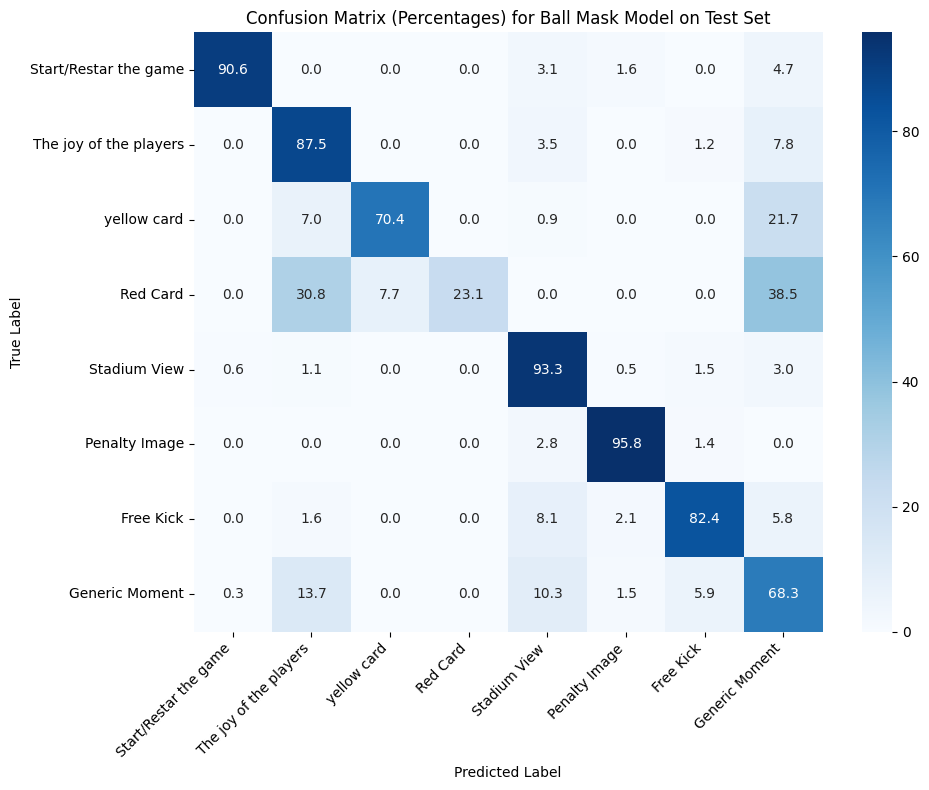

In [23]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Ball Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

overall_accuracy = sum(class_correct) / sum(class_total) * 100

print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")

Class                      Accuracy
-----------------------------------
Start/Restar the game        90.62
The joy of the players       87.55
yellow card                  70.43
Red Card                     23.08
Stadium View                 93.33
Penalty Image                95.83
Free Kick                    82.37
Generic Moment               68.30
-----------------------------------
Overall                      83.60


In [25]:
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.836
Weighted Precision: 0.841
Weighted Recall: 0.836
Weighted F1 Score: 0.834


---
## 2. Gate masked inputs

In [32]:
image_path = 'data/selected_images'
mask_path = 'data/Gate_Mask'

In [ ]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)
labels = labels.drop(columns=LABELS)


In [33]:
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='resnet18_masked_Gate.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]
Input tensor shape: torch.Size([32, 4, 224, 224])
[1/10] Train Loss: 0.8587, Acc: 70.26%, Val Loss: 0.9297, Acc: 66.00%
Saved new best model!

[2/10] Train Loss: 0.5593, Acc: 80.40%, Val Loss: 0.5277, Acc: 80.50%
Saved new best model!

[3/10] Train Loss: 0.4486, Acc: 84.32%, Val Loss: 0.5681, Acc: 81.00%
[4/10] Train Loss: 0.3727, Acc: 87.17%, Val Loss: 0.6179, Acc: 82.75%
[5/10] Train Loss: 0.2862, Acc: 90.29%, Val Loss: 0.6453, Acc: 78.75%
[6/10] Train Loss: 0.2322, Acc: 92.01%, Val Loss: 0.6898, Acc: 78.00%
[7/10] Train Loss: 0.2054, Acc: 92.76%, Val Loss: 0.5839, Acc: 82.88%
[8/10] Train Loss: 0.1661, Acc: 94.25%, Val Loss: 0.6816, Acc: 81.88%
[9/10] Train Loss: 0.1323, Acc: 95.53%, Val Loss: 0.9336, Acc: 73.38%
[10/10] Train Loss: 0.1007, Acc: 96.46%, Val Loss: 0.6815, Acc: 80.62%
Training complete.


### Evaluation metrics

In [35]:
gatemask_model = ResNet18With4Channels(num_classes=len(LABELS))
gatemask_model.load_state_dict(torch.load('resnet18_masked_Gate.pth'))
gatemask_model.to(device)
gatemask_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [36]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)


                        precision    recall  f1-score   support

 Start/Restar the game      0.868     0.922     0.894        64
The joy of the players      0.921     0.591     0.720       257
           yellow card      0.959     0.809     0.877       115
              Red Card      0.667     0.769     0.714        13
          Stadium View      0.932     0.847     0.887       660
         Penalty Image      0.859     0.931     0.893        72
             Free Kick      0.837     0.896     0.865       431
        Generic Moment      0.624     0.830     0.712       388

              accuracy                          0.824      2000
             macro avg      0.833     0.824     0.821      2000
          weighted avg      0.845     0.824     0.826      2000



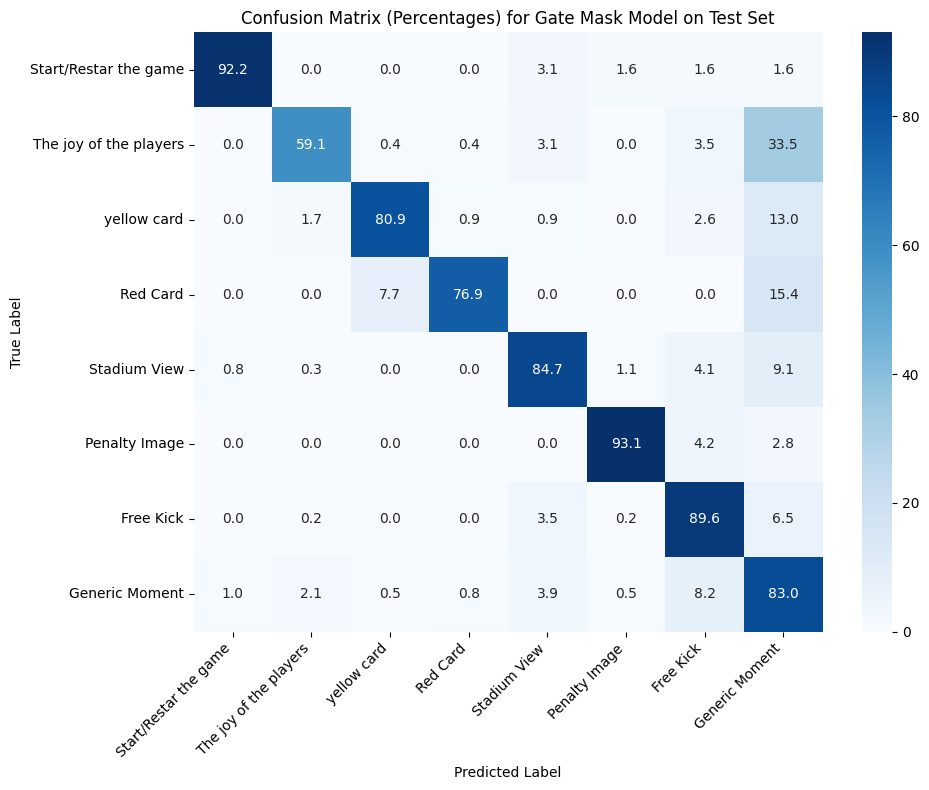

In [37]:
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Gate Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
overall_accuracy = sum(class_correct) / sum(class_total) * 100

print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")


Class                      Accuracy
-----------------------------------
Start/Restar the game        92.19
The joy of the players       59.14
yellow card                  80.87
Red Card                     76.92
Stadium View                 84.70
Penalty Image                93.06
Free Kick                    89.56
Generic Moment               82.99
-----------------------------------
Overall                      82.40


In [39]:
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.824
Weighted Precision: 0.845
Weighted Recall: 0.824
Weighted F1 Score: 0.826


---
## 3. Referee masked inputs

In [27]:
mask_path = 'data/Ref_Mask'

In [28]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)
labels = labels.drop(columns=LABELS)


In [29]:
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='resnet18_masked_Referee.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]


Input tensor shape: torch.Size([32, 4, 224, 224])
[1/10] Train Loss: 0.1223, Acc: 95.83%, Val Loss: 0.7388, Acc: 81.00%
Saved new best model!

[2/10] Train Loss: 0.0864, Acc: 97.12%, Val Loss: 0.8234, Acc: 80.88%
[3/10] Train Loss: 0.0757, Acc: 97.28%, Val Loss: 0.6043, Acc: 85.12%
Saved new best model!

[4/10] Train Loss: 0.0871, Acc: 97.07%, Val Loss: 0.7157, Acc: 81.50%
[5/10] Train Loss: 0.0668, Acc: 97.78%, Val Loss: 0.7002, Acc: 84.62%
[6/10] Train Loss: 0.0757, Acc: 97.62%, Val Loss: 0.7751, Acc: 82.12%
[7/10] Train Loss: 0.0292, Acc: 99.07%, Val Loss: 0.7229, Acc: 83.50%
[8/10] Train Loss: 0.0429, Acc: 98.68%, Val Loss: 0.8715, Acc: 82.62%
[9/10] Train Loss: 0.0870, Acc: 97.42%, Val Loss: 0.6275, Acc: 85.00%
[10/10] Train Loss: 0.0354, Acc: 98.78%, Val Loss: 0.9409, Acc: 83.62%
Training complete.


### Evaluation metrics

In [40]:
gatemask_model = ResNet18With4Channels(num_classes=len(LABELS))
gatemask_model.load_state_dict(torch.load('resnet18_masked_Referee.pth'))
gatemask_model.to(device)
gatemask_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [41]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.917     0.859     0.887        64
The joy of the players      0.785     0.840     0.812       257
           yellow card      0.831     0.852     0.841       115
              Red Card      0.800     0.615     0.696        13
          Stadium View      0.933     0.891     0.912       660
         Penalty Image      1.000     0.431     0.602        72
             Free Kick      0.824     0.903     0.862       431
        Generic Moment      0.683     0.711     0.697       388

              accuracy                          0.831      2000
             macro avg      0.847     0.763     0.789      2000
          weighted avg      0.837     0.831     0.829      2000



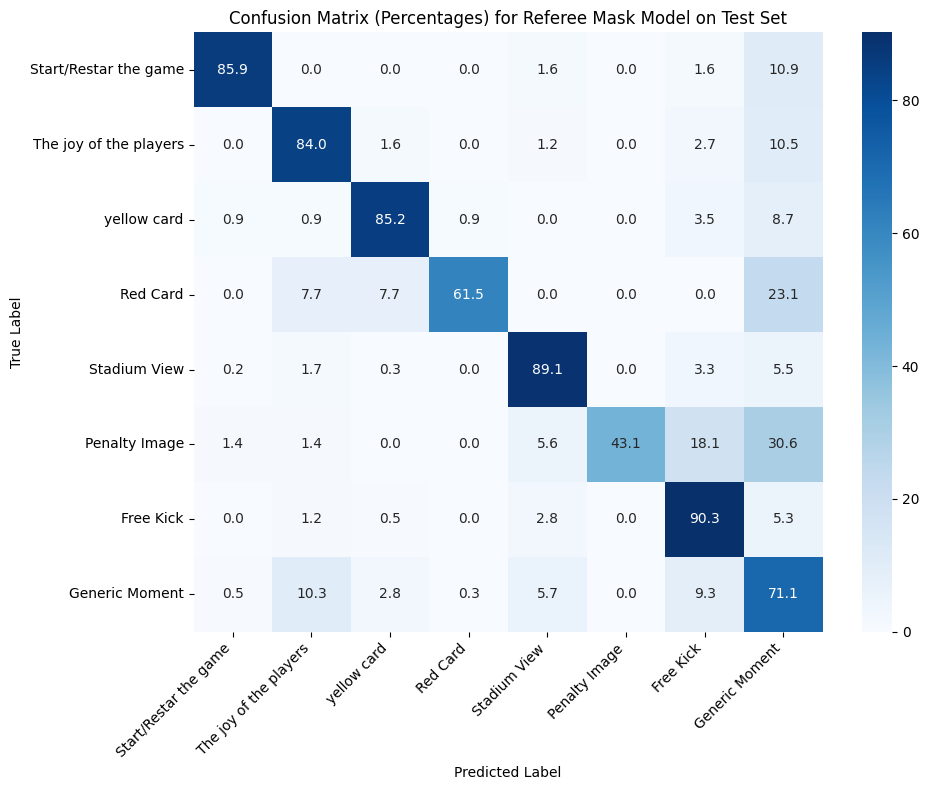

In [42]:
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Referee Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [43]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
overall_accuracy = sum(class_correct) / sum(class_total) * 100

# per-class accuracy table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")


Class                      Accuracy
-----------------------------------
Start/Restar the game        85.94
The joy of the players       84.05
yellow card                  85.22
Red Card                     61.54
Stadium View                 89.09
Penalty Image                43.06
Free Kick                    90.26
Generic Moment               71.13
-----------------------------------
Overall                      83.05


In [44]:
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.831
Weighted Precision: 0.837
Weighted Recall: 0.831
Weighted F1 Score: 0.829
